# some insight on what the embedding layer does..

In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import Embedding

# each new model will provide a different set of embeddings
model = Sequential()
input_array = np.array([[ 1, 2, 3, 2,99],
                        [20,30,40,50,60]
                       ])

# this layer converts a sequence of integers to a fixed dimension vector of floats
model.add(Embedding(100, 4, input_length=5))
model.compile('rmsprop', 'mse')

# can be used to predict any number of samples
output_array = model.predict(input_array)
assert output_array.shape == (2, 5, 4)

# check that all elements meant to be equal are..
# used the 'array_equal' function
assert (np.array_equal(output_array[0][1],output_array[0][3]))

print (input_array)
print (output_array)

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


[[ 1  2  3  2 99]
 [20 30 40 50 60]]
[[[-0.03357483  0.03608015  0.01297964 -0.03611078]
  [-0.0013414   0.01265285 -0.04347279  0.00564732]
  [ 0.0120943  -0.03486428  0.04279834  0.02152374]
  [-0.0013414   0.01265285 -0.04347279  0.00564732]
  [ 0.03026238  0.03241466 -0.03797972  0.0039479 ]]

 [[-0.01915991  0.01246355 -0.02333621 -0.02265028]
  [-0.00818653  0.00797934 -0.03463236  0.0441787 ]
  [-0.04911791 -0.04545338 -0.00148395  0.03011576]
  [ 0.02829078  0.00856111 -0.02306349  0.0397087 ]
  [-0.0487126   0.04053981  0.04936567 -0.02675781]]]


# working with IMDB + embedding layer + dense clasifier

In [3]:
# hyper parameters
# take the top 'max_features' words
max_features = 20000

# changing this from 40 to 100 helps increase val_acc by 6-7%
maxlen = 100

In [4]:
from keras.datasets import imdb
from keras import preprocessing

# load the data
(x_train_orig, y_train), (x_test_orig, y_test) = imdb.load_data(num_words=max_features)

# pad sequences with length < maxlen with 0
x_train = preprocessing.sequence.pad_sequences(x_train_orig, maxlen=maxlen)
x_test  = preprocessing.sequence.pad_sequences(x_test_orig,  maxlen=maxlen)

In [6]:
# get sme idea about the input (raw) IMDB data & modified
max_len = [-1,-1]
min_len = [1000000,-1]
for indx,val in enumerate(x_test_orig):
    val_len = len(val)
    if (val_len > max_len[0]):
        max_len[0] = val_len
        max_len[1] = indx
        
    if (val_len < min_len[0]):
        min_len[0] = val_len
        min_len[1] = indx
        
print ("LENGTH: RAW: max_len=%d(@%d) min_len=%d(@%d)" %(max_len[0],max_len[1],min_len[0],min_len[1]))
print ("SHAPE: ","RAW:",x_test_orig.shape,"FIN:",x_train.shape)
print ("SHAPE: ","FIN:",y_train.shape)

LENGTH: RAW: max_len=2315(@20338) min_len=7(@2104)
SHAPE:  RAW: (25000,) FIN: (25000, 100)
SHAPE:  FIN: (25000,)


In [7]:
# check the entry that's supposed to be padded!
print ("RAW:X=",x_test_orig[min_len[1]],"Y=",y_test[min_len[1]])
print ("MOD:",x_test     [min_len[1]])

RAW:X= [1, 332, 4, 274, 859, 4, 20] Y= 0
MOD: [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   1 332   4 274 859   4  20]


# embedding layer

In [7]:
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Flatten, Dense, Dropout
from keras import regularizers
import matplotlib.pyplot as plt

def train_model(dropout=0,regularize=0,epochs=10,embed_dim=8,shuffle_val_data=1):
    model = Sequential()
    model.add(Embedding(input_dim=max_features, output_dim=embed_dim, input_length=maxlen))
    if dropout:
        model.add(Dropout(0.5))
        
    model.add(Flatten())
    
    if regularize:
        l2_val=0.01
        model.add(Dense(1, activation='sigmoid',kernel_regularizer=regularizers.l2(l2_val)))
    else:
        model.add(Dense(1, activation='sigmoid'))
        
    #model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
    model.summary()

    # train
    total_train_samples = x_train.shape[0]
    train_size = int(0.8 * total_train_samples)
    print ("INFO: total_train_size=%d train_size=%d" %(total_train_samples,train_size))
    
    # set val_data
    x_val = x_train[train_size:]
    y_val = y_train[train_size:]
    print ("VAL_SHAPE: x_val=%s y_val=%s" %(x_val.shape, y_val.shape))
    
    debug=0
    if shuffle_val_data:
        print ("INFO: validation data shuffle enabled")
        for indx,x_ent in enumerate(x_val):
            np.random.shuffle(x_ent)
            x_val[indx] = x_ent
            
    history = model.fit(x_train[:train_size], y_train[:train_size],
                        validation_data=(x_val,y_val),
                        epochs=epochs,
                        batch_size=32,
                        verbose=1)

    # plot
    plt.plot(history.history['loss'],    label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.legend()
    plt.figure()

    plt.plot(history.history['acc'],    label='acc')
    plt.plot(history.history['val_acc'],label='val_acc')
    plt.legend()
    plt.show()

# without regularization
 - classic over-fit case!

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_48 (Embedding)     (None, 100, 8)            160000    
_________________________________________________________________
flatten_7 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 801       
Total params: 160,801
Trainable params: 160,801
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 3s 131us/step - loss: 0.6221 - acc: 0.6784 - val_loss: 0.4754 - val_acc: 0.8034
Epoch 2/30
20000/20000 [==============================] - 2s 123us/step - loss: 0.3701 - acc: 0.8513 - val_loss: 0.3515 - val_acc: 0.8480
Epoch 3/30
20000/20000 [==============================] - 2s 111us/step - l

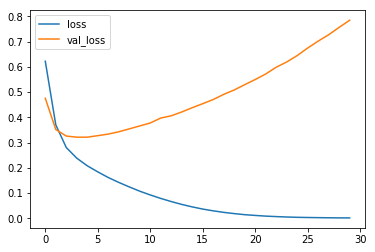

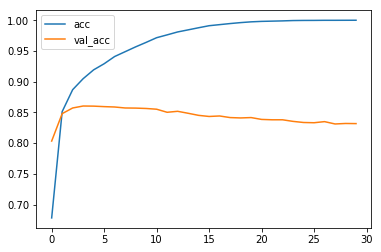

In [87]:
train_model(epochs=30)

# with regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_49 (Embedding)     (None, 100, 8)            160000    
_________________________________________________________________
flatten_8 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 801       
Total params: 160,801
Trainable params: 160,801
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 4s 185us/step - loss: 0.6426 - acc: 0.6975 - val_loss: 0.5459 - val_acc: 0.8008
Epoch 2/30
20000/20000 [==============================] - 3s 140us/step - loss: 0.4836 - acc: 0.8409 - val_loss: 0.4653 - val_acc: 0.8380
Epoch 3/30
20000/20000 [==============================] - 3s 167us/step - l

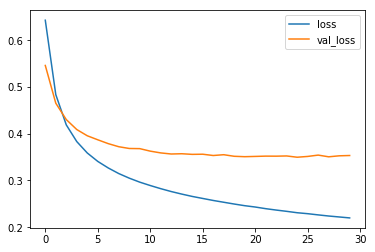

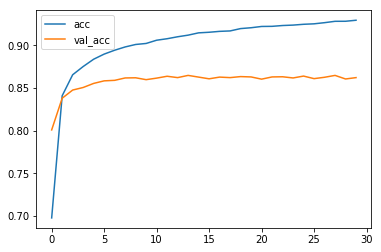

In [88]:
train_model(regularize=1,epochs=30)

# with regularization + dropout

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_50 (Embedding)     (None, 100, 8)            160000    
_________________________________________________________________
dropout_3 (Dropout)          (None, 100, 8)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 801       
Total params: 160,801
Trainable params: 160,801
Non-trainable params: 0
_________________________________________________________________
Train on 20000 samples, validate on 5000 samples
Epoch 1/50
20000/20000 [==============================] - 5s 259us/step - loss: 0.6746 - acc: 0.6402 - val_loss: 0.6063 - val_acc: 0.7682
Epoch 2/50
20000/20000 [==============================] - 3s 168us/step - loss: 0

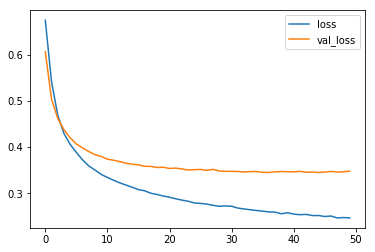

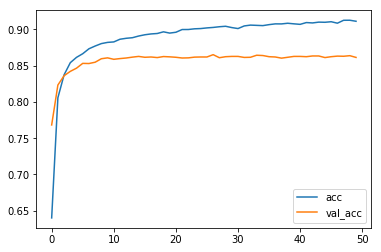

In [89]:
train_model(dropout=1,regularize=1,epochs=50)

# embedding layer with words in validation data shuffled
notice how this doesn't have an effect

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 100, 8)            160000    
_________________________________________________________________
flatten_2 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 801       
Total params: 160,801
Trainable params: 160,801
Non-trainable params: 0
_________________________________________________________________
INFO: total_train_size=25000 train_size=20000
VAL_SHAPE: x_val=(5000, 100) y_val=(5000,)
INFO: validation data shuffle enabled
Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 2s 125us/step - loss: 0.6097 - acc: 0.6902 - val_loss: 0.4660 - val_acc: 0.8060
Epoch 2/5
20000/20000 [==============================] - 2s 92us/step - loss: 0.3576 - 

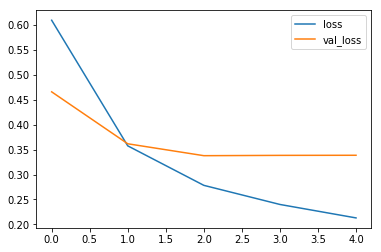

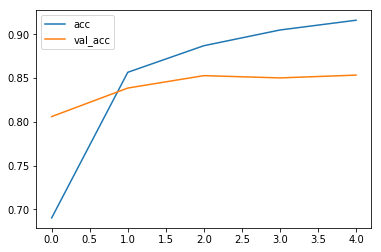

In [8]:
train_model(epochs=5)

# simpleRNN

In [391]:
# simple RNN like implementation with numpy
import numpy as np

timesteps       = 10
input_features  = 2
output_features = 4

inputs = np.random.random((timesteps, input_features))

state_t = np.zeros((output_features,))

W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))

successive_outputs = []
for input_t in inputs:
    # tanh => -1,1
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    #  store all outputs
    successive_outputs.append(output_t)
    
    # state_t is now used in the next timestamp
    state_t = output_t

print(len(successive_outputs))
final_output_sequence = np.concatenate(successive_outputs, axis=0)
print(final_output_sequence.shape)

10
(40,)


In [13]:
from keras.layers import Dense
from keras.layers import SimpleRNN

def train_simpleRNN(epochs=10,shuffle_val_data=0,batch_size=128):
    # using the data already read from the IMDB, but, using the first 500 words this time
    long_len = 500

    # pad sequences with length < maxlen with 0
    x_train_long = preprocessing.sequence.pad_sequences(x_train_orig, maxlen=long_len)
    x_test_long  = preprocessing.sequence.pad_sequences(x_test_orig,  maxlen=long_len)

    total_train_samples = x_train.shape[0]
    train_size = int(0.8 * total_train_samples)
    print ("INFO: total_train_size=%d train_size=%d" %(total_train_samples,train_size))
    
    x_train_tst = x_train_long[:train_size] #np.random.randint(low=0,high=max_features,size=(100,20))
    y_train_tst = y_train     [:train_size] #np.random.randint(low=0,high=2           ,size=(100))
    x_val       = x_train_long[train_size:]
    y_val       = y_train     [train_size:]

    print ("TRAIN_SHAPE:x=%s y=%s" %(x_train_tst.shape,y_train_tst.shape))

    if shuffle_val_data:
            print ("INFO: validation data shuffle enabled")
            for indx,x_ent in enumerate(x_val):
                np.random.shuffle(x_ent)
                x_val[indx] = x_ent

    model = Sequential()
    model.add(Embedding(max_features, 64))
    model.add(SimpleRNN(64))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

    history = model.fit(x_train_tst, y_train_tst,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val,y_val))

# simpleRNN without validation-data shuffle
notice that the validation accuracy is high

In [17]:
train_simpleRNN(epochs=10,shuffle_val_data=0)

INFO: total_train_size=25000 train_size=15000
TRAIN_SHAPE:x=(15000, 500) y=(15000,)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 64)          1280000   
_________________________________________________________________
simple_rnn_6 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 1,288,321
Trainable params: 1,288,321
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 45s 3ms/step - loss: 0.6538 - acc: 0.6025 - val_loss: 0.4750 - val_acc: 0.7787
Epoch 2/10
15000/15000 [==============================] - 43s 3ms/step - loss: 0.4131 - acc: 0.8155 - val_loss: 0.4163 - val_

# simpleRNN with validation-data shuffle
notice that the validation accuracy is now lower .. this is as expected, with RNN, the order of the words matter

In [16]:
train_simpleRNN(epochs=10,shuffle_val_data=1)

INFO: total_train_size=25000 train_size=15000
TRAIN_SHAPE:x=(15000, 500) y=(15000,)
INFO: validation data shuffle enabled
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 64)          1280000   
_________________________________________________________________
simple_rnn_5 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 1,288,321
Trainable params: 1,288,321
Non-trainable params: 0
_________________________________________________________________
Train on 15000 samples, validate on 10000 samples
Epoch 1/10
15000/15000 [==============================] - 43s 3ms/step - loss: 0.6670 - acc: 0.5820 - val_loss: 0.7651 - val_acc: 0.5595
Epoch 2/10
15000/15000 [==============================] - 42s 3ms/step - loss: 0.4628 -